In [3]:
# Natural Language
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [5]:
# Visualization
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC

In [6]:
import os

# List contents of the current directory
print("Contents of the current directory:")
print(os.listdir('.'))

# List contents of the aclImdb directory
if os.path.exists('./aclImdb'):
    print("Contents of the aclImdb directory:")
    print(os.listdir('./aclImdb'))
else:
    print("The aclImdb directory does not exist in the current directory.")


Contents of the current directory:
['.ipynb_checkpoints', 'aclImdb', 'imdb.ipynb']
Contents of the aclImdb directory:
['.ipynb_checkpoints', 'imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


In [7]:
def load_imdb_data(data_dir):
    data = {'review': [], 'sentiment': []}
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(data_dir, split, sentiment)
            print(f"Checking path: {path}")  # Debug print statement
            if not os.path.exists(path):
                raise FileNotFoundError(f"Directory {path} does not exist")
            for filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        data['review'].append(file.read())
                        data['sentiment'].append(1 if sentiment == 'pos' else 0)
    return pd.DataFrame(data)

# Load the data
data_dir = './aclImdb'
imdb_df = load_imdb_data(data_dir)
print(imdb_df.head())

Checking path: ./aclImdb\train\pos
Checking path: ./aclImdb\train\neg
Checking path: ./aclImdb\test\pos
Checking path: ./aclImdb\test\neg
                                              review  sentiment
0  Bromwell High is a cartoon comedy. It ran at t...          1
1  Homelessness (or Houselessness as George Carli...          1
2  Brilliant over-acting by Lesley Ann Warren. Be...          1
3  This is easily the most underrated film inn th...          1
4  This is not the typical Mel Brooks film. It wa...          1


In [8]:
# Basic summary statistics
print(imdb_df.info())
print(imdb_df['sentiment'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None
sentiment
1    25000
0    25000
Name: count, dtype: int64


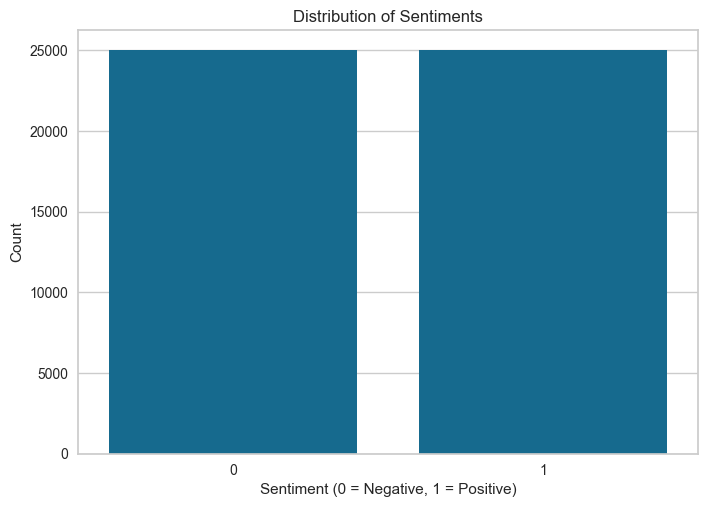

In [9]:
# Visualize the distribution of sentiments
sns.countplot(x='sentiment', data=imdb_df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()


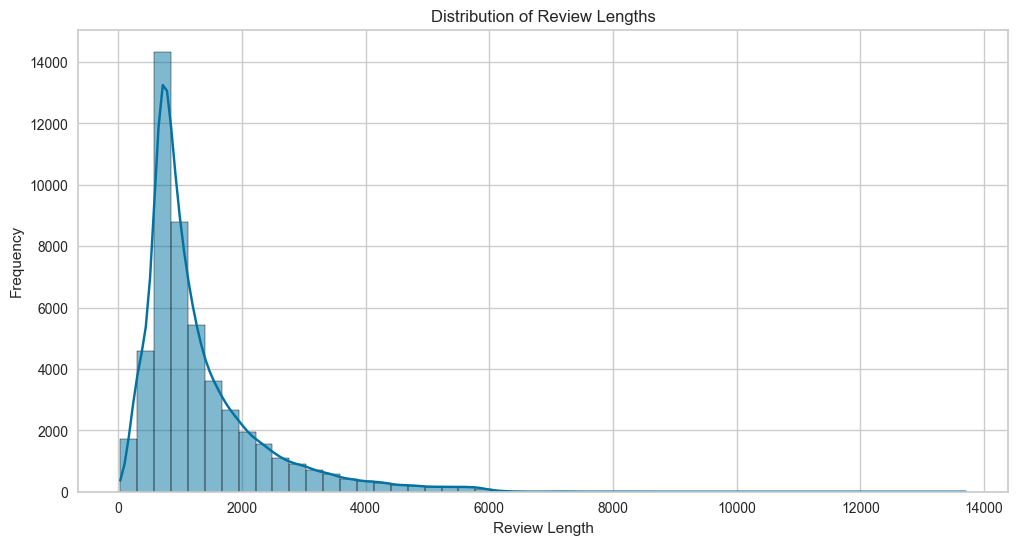

In [10]:
# Add a column for the length of each review
imdb_df['review_length'] = imdb_df['review'].apply(len)

# Visualize the distribution of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(imdb_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


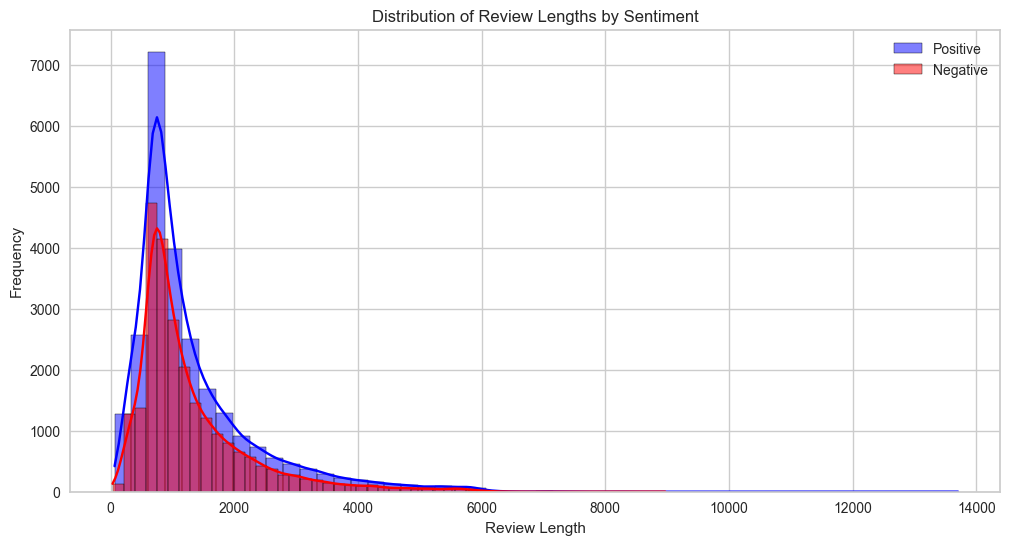

In [11]:
# Add a column for the length of each review
imdb_df['review_length'] = imdb_df['review'].apply(len)

# Visualize the distribution of review lengths, differentiated by sentiment
plt.figure(figsize=(12, 6))

# Plot positive reviews
sns.histplot(imdb_df[imdb_df['sentiment'] == 1]['review_length'], bins=50, kde=True, color='blue', label='Positive')

# Plot negative reviews
sns.histplot(imdb_df[imdb_df['sentiment'] == 0]['review_length'], bins=50, kde=True, color='red', label='Negative')

plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [12]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Clean the reviews and tokenize, excluding stopwords
imdb_df['cleaned_review'] = imdb_df['review'].apply(clean_text)

pos_words = [word for word in ' '.join(imdb_df[imdb_df['sentiment'] == 1]['cleaned_review']).split() if word.lower() not in stop_words]
neg_words = [word for word in ' '.join(imdb_df[imdb_df['sentiment'] == 0]['cleaned_review']).split() if word.lower() not in stop_words]

# Get word frequencies
pos_word_freq = Counter(pos_words)
neg_word_freq = Counter(neg_words)

# Get the top 20 most common words and their frequencies for positive reviews
pos_common_words = pos_word_freq.most_common(20)
pos_words, pos_counts = zip(*pos_common_words)

# Get the top 20 most common words and their frequencies for negative reviews
neg_common_words = neg_word_freq.most_common(20)
neg_words, neg_counts = zip(*neg_common_words)

# Plot word frequency distribution for positive and negative reviews
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(pos_words, pos_counts, color='skyblue')
plt.title('Top 20 Words in Positive Reviews (Excluding Stopwords)')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(neg_words, neg_counts, color='salmon')
plt.title('Top 20 Words in Negative Reviews (Excluding Stopwords)')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

NameError: name 'stop_words' is not defined

**Logistic Regression**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Accuracy:  0.8964
Precision:  0.8887599148771522
Recall:  0.9088031651829871
F1 Score:  0.8986697965571205
Confusion Matrix: 
 [[4370  575]
 [ 461 4594]]


In [15]:
# initial log reg parameters pre tuning
model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Accuracy:  0.8964
Precision:  0.8887599148771522
Recall:  0.9088031651829871
F1 Score:  0.8986697965571205
Confusion Matrix: 
 [[4370  575]
 [ 461 4594]]


In [16]:

# Adjust hyperparameters manually
# Example: Increase regularization strength
model = LogisticRegression(penalty='l2', C=0.5, solver='lbfgs', max_iter=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model after adjustment
print("\nModel Performance after Adjusting Regularization Strength:")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Model Performance after Adjusting Regularization Strength:
Accuracy:  0.894
Precision:  0.8862889189711854
Recall:  0.9066271018793274
F1 Score:  0.8963426559749658
Confusion Matrix: 
 [[4357  588]
 [ 472 4583]]


In [17]:

# Adjust hyperparameters manually
# Example: Increase regularization strength
model = LogisticRegression(penalty='l2', C=3, solver='liblinear', max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model after adjustment
print("\nModel Performance after Adjusting Regularization Strength:")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Model Performance after Adjusting Regularization Strength:
Accuracy:  0.8993
Precision:  0.8942345149980522
Recall:  0.9082096933728981
F1 Score:  0.901167926194916
Confusion Matrix: 
 [[4402  543]
 [ 464 4591]]


In [18]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Print classification report
print("Classification Report:")
print("{:<10} {:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1-Score', 'Support'))
for key, value in report.items():
    if key not in ['accuracy', 'macro avg', 'weighted avg']:
        print("{:<10} {:<10.4f} {:<10.4f} {:<10.4f} {:<10}".format(key, value['precision'], value['recall'], value['f1-score'], value['support']))

# Print additional metrics
print("\nAdditional Metrics:")
print("Accuracy: ", report['accuracy'])
print("Macro Avg Precision: ", report['macro avg']['precision'])
print("Macro Avg Recall: ", report['macro avg']['recall'])
print("Macro Avg F1-Score: ", report['macro avg']['f1-score'])
print("Weighted Avg Precision: ", report['weighted avg']['precision'])
print("Weighted Avg Recall: ", report['weighted avg']['recall'])
print("Weighted Avg F1-Score: ", report['weighted avg']['f1-score'])


Classification Report:
Class      Precision  Recall     F1-Score   Support   
0          0.9046     0.8902     0.8974     4945.0    
1          0.8942     0.9082     0.9012     5055.0    

Additional Metrics:
Accuracy:  0.8993
Macro Avg Precision:  0.8994394934217552
Macro Avg Recall:  0.8992009033093005
Macro Avg F1-Score:  0.8992640160991907
Weighted Avg Precision:  0.8993822386590946
Weighted Avg Recall:  0.8993
Weighted Avg F1-Score:  0.8992849591102436


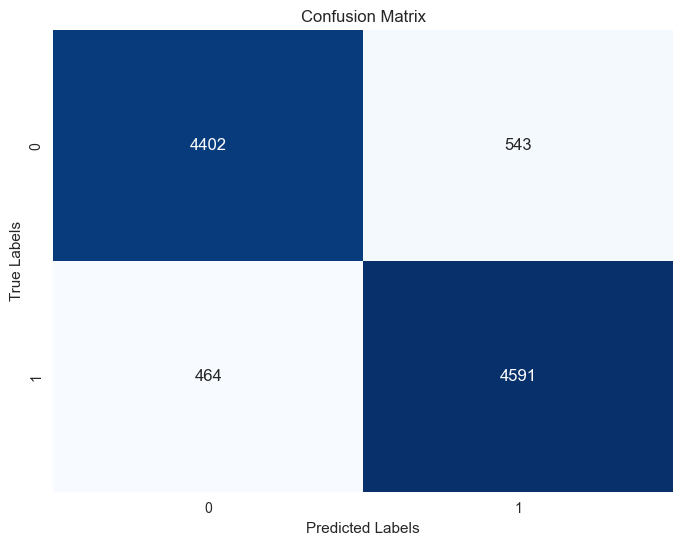

In [19]:
# Logistic Regression Metrics
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Training Accuracy: 0.9329
Testing Accuracy: 0.8993


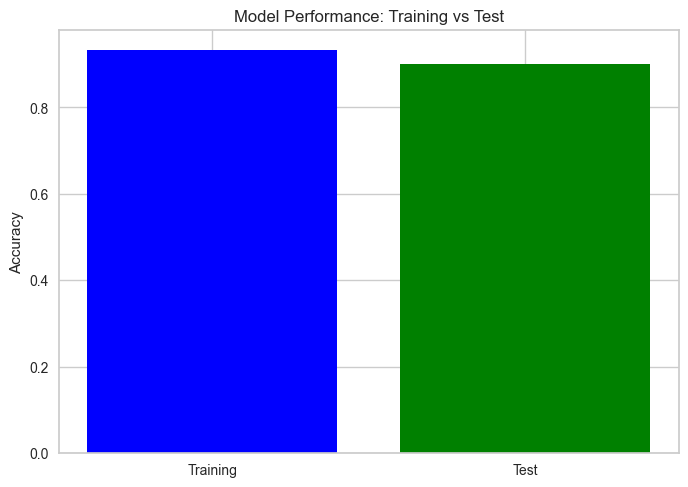

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Train a new logistic regression model
model_train = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=100)
model_train.fit(X_train, y_train)

# Evaluate the model on the training data
train_accuracy = model_train.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Plotting the comparison
labels = ['Training', 'Test']
accuracy_values = [train_accuracy, accuracy_score(y_test, y_pred)]
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.title('Model Performance: Training vs Test')
plt.ylabel('Accuracy')
plt.show()


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Decision Tree Classifier with some starting parameters
tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

# Fit the model on the training data
print("Fitting the Decision Tree Classifier...")
tree_classifier.fit(X_train, y_train)
print("Done.")

# Make predictions on the test data
print("Making predictions...")
y_pred = tree_classifier.predict(X_test)
print("Done.")

# Evaluate the model
print("\nModel Performance:")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))


Fitting the Decision Tree Classifier...
Done.
Making predictions...
Done.

Model Performance:
Accuracy:  0.7347
Precision:  0.7415526950925181
Recall:  0.7293768545994065
F1 Score:  0.7354143811708387
Confusion Matrix: 
 [[3660 1285]
 [1368 3687]]


In [24]:
dt_classifier = DecisionTreeClassifier(max_depth=15, min_samples_split=5, min_samples_leaf=5, criterion='gini', max_features=None)

print("Fitting the Decision Tree Classifier...")
# Fit the model on the training data
dt_classifier.fit(X_train, y_train)
print("Done.")

print("Making predictions...")
# Make predictions on the test data
y_pred_dt = dt_classifier.predict(X_test)
print("Done.")

# Evaluate the model
print("\nModel Performance:")
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print("Recall: ", recall_score(y_test, y_pred_dt))
print("F1 Score: ", f1_score(y_test, y_pred_dt))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_dt))

Fitting the Decision Tree Classifier...
Done.
Making predictions...
Done.

Model Performance:
Accuracy:  0.7365
Precision:  0.6963648166179812
Recall:  0.848862512363996
F1 Score:  0.7650887046447357
Confusion Matrix: 
 [[3074 1871]
 [ 764 4291]]


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier with some default parameters
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')

print("Fitting the Random Forest Classifier...")
# Fit the model on the training data
rf_classifier.fit(X_train, y_train)
print("Done.")

print("Making predictions...")
# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)
print("Done.")

# Evaluate the model
print("\nModel Performance:")
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rf))


Fitting the Random Forest Classifier...
Done.
Making predictions...
Done.

Model Performance:
Accuracy:  0.8579
Precision:  0.8693089430894309
Recall:  0.8460929772502472
F1 Score:  0.8575438596491228
Confusion Matrix: 
 [[4302  643]
 [ 778 4277]]


In [28]:
# better RF?
rf_classifier = RandomForestClassifier(
    n_estimators=200,       # Increase the number of trees
    max_depth=15,           # Adjust the maximum depth of the trees
    min_samples_split=5,    # Adjust the minimum number of samples required to split an internal node
    min_samples_leaf=2,     # Adjust the minimum number of samples required to be at a leaf node
    max_features='sqrt',    # Number of features to consider when looking for the best split
    random_state=42,        # For reproducibility
    n_jobs=-1               # Use all available cores
)

print("Fitting the Random Forest Classifier...")
# Fit the model on the training data
rf_classifier.fit(X_train, y_train)
print("Done.")

print("Making predictions...")
# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)
print("Done.")

print("\nModel Performance:")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting the Random Forest Classifier...
Done.
Making predictions...
Done.

Model Performance:
Accuracy:  0.8424
Precision:  0.8287658287658287
Recall:  0.8674579624134521
F1 Score:  0.8476705973323023
Confusion Matrix: 
 [[4039  906]
 [ 670 4385]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4945
           1       0.83      0.87      0.85      5055

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000




Model Performance:
Accuracy:  0.8579
Precision:  0.8693089430894309
Recall:  0.8460929772502472
F1 Score:  0.8575438596491228
Confusion Matrix: 
 [[4302  643]
 [ 778 4277]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4945
           1       0.87      0.85      0.86      5055

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



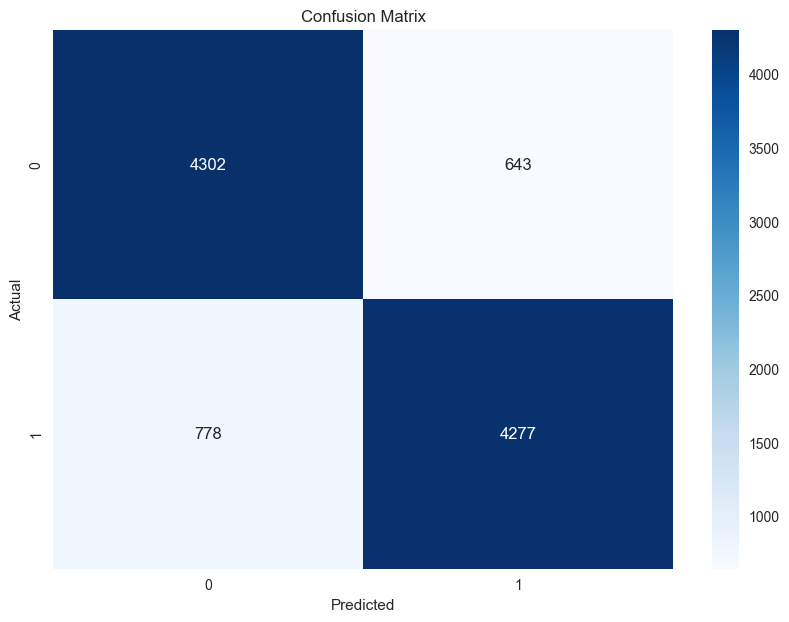

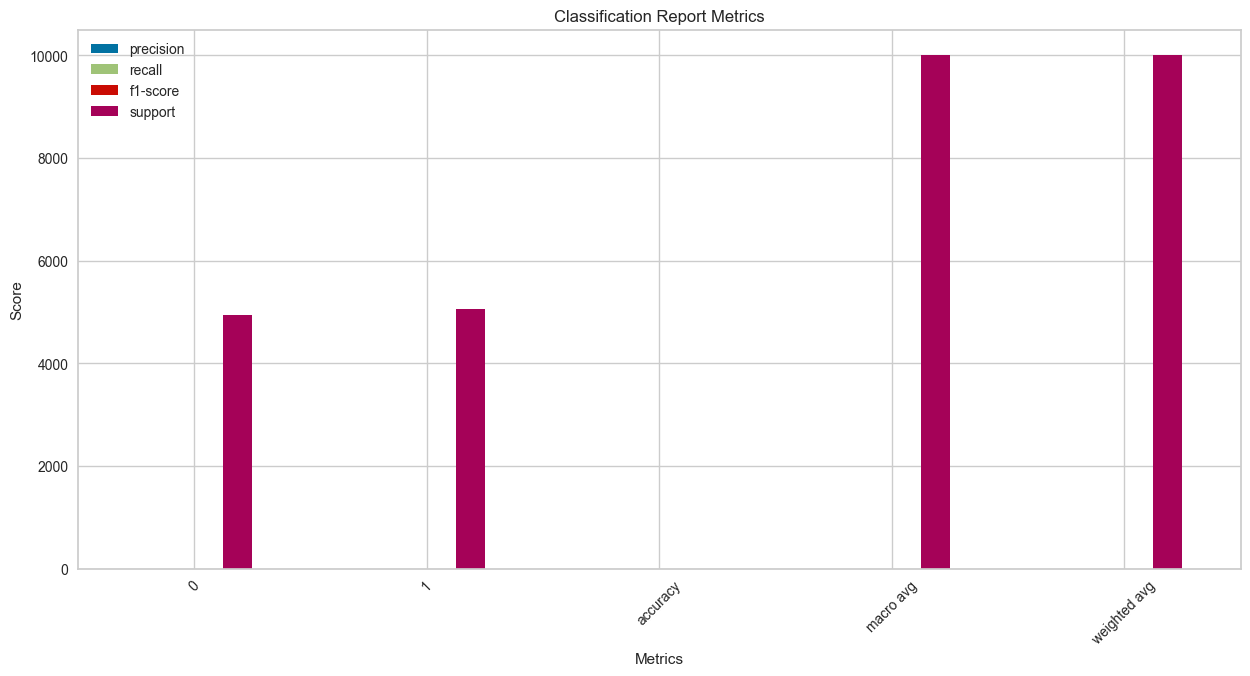

In [27]:
# Evaluate the model
print("\nModel Performance:")
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix: \n", conf_matrix)

# Classification report
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf)
print(report)

# Visualization
# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Bar plot for classification report
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

report_df.plot(kind='bar', figsize=(15, 7))
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

Fitting the Random Forest Classifier...
Done.
Training Accuracy: 1.0
Making predictions...
Done.
Testing Accuracy: 0.8548


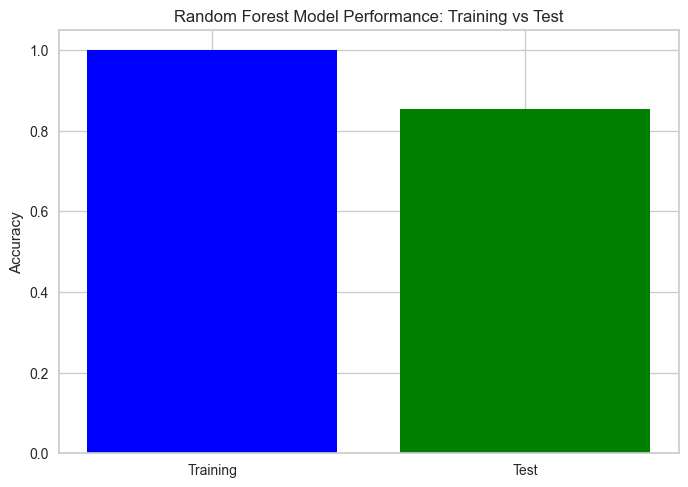

In [29]:
# Define and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
print("Fitting the Random Forest Classifier...")
rf_classifier.fit(X_train, y_train)
print("Done.")

# Evaluate the model on the training data
train_accuracy = rf_classifier.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Make predictions on the test data
print("Making predictions...")
y_pred = rf_classifier.predict(X_test)
print("Done.")

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", test_accuracy)

# Plotting the comparison
labels = ['Training', 'Test']
accuracy_values = [train_accuracy, test_accuracy]

plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.title('Random Forest Model Performance: Training vs Test')
plt.ylabel('Accuracy')
plt.show()

In [30]:
# Get the predicted labels for the test data
y_pred = rf_classifier.predict(X_test)

# Identify misclassified examples
misclassified_idx = np.where(y_pred != y_test)[0]

# Print or visualize the misclassified examples
for idx in misclassified_idx:
    predicted_label = y_pred[idx]
    true_label = y_test[idx]
    print(f"Predicted: {predicted_label}, True: {true_label}")


KeyError: 1